In [42]:
import os
import sys
import logging
import mlflow
import joblib

import pandas as pd
import numpy as np

from minio import Minio

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor, Ridge, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor


from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# settings
MINIO_HOST = os.environ.get('MINIO_HOST', '')
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', '')
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', '')

os.environ['MLFLOW_TRACKING_URI'] = ""
os.environ['MLFLOW_S3_ENDPOINT_URL'] = ""
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

CATEGORICAL_COLUMNS = [
            'DG_1_condition', 'DG_2_condition',
            'DG_4_condition',
            'DG_5_condition', 'ship_inclination'
        ]
DATE_COL = ['measurement_time']
NUMERICAL_COLUMNS = [
            'AE_FO_consumption', 'available_max_power',
            'crankcase_press', 'cyl_chargeair_press',
            'draught_aft_side', 'draught_fore_side',
            'engine_speed', 'ME_FO_consumption',
            'propeller_shaft_output', 'propeller_shaft_rpm',
            'propeller_shaft_thrust', 'cyl_chargeair_temp',
            'ship_speed_actual', 'Ship_SpeedLOG',
            'cyl_exh_gas_temp_mean', 'torque',
            'AE_FO_outlet_flow', 'AE_FO_outlet_Temp',
            'Eng_in_HTCW_press', 'Eng_in_Jacket_HTCW_temp',
            'Eng_out_Jacket_HTCW_temp', 'Eng_Relative_load',
            'FO_Rack_position', 'FO_inlet_press',
            'fueloil_inlet_temperature', 'ME_FO_inlet_flow',
            'ME_FO_outlet_Temp', 'ME_FO_outlet_flow',
            'LO_Filter_P', 'LO_filter_in_press',
            'LO_in_press', 'LO_in_temp',
            'LO_out_temp_TC', 'LO_cooler_CW_out_temp'
        ]
NEW_COLUMNS = ['vessel_fuel_consumption']

FOR_NORMALIZATION_COLS = NUMERICAL_COLUMNS + NEW_COLUMNS

ABORT_COLS = ['vessel_fuel_consumption', 'AE_FO_consumption', 'ME_FO_consumption', 'measurement_time']


logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

In [3]:
class LoadDataSet(object):
    def __init__(self):
        self.random_state = 42
        self.bucket = 'uploads'
        self.directory = 'data'

        self.new_columns = NEW_COLUMNS
        self.date_col = DATE_COL

        self.numerical_columns = NUMERICAL_COLUMNS
        self.categorical_columns = CATEGORICAL_COLUMNS

        self.columns_used = self.date_col + self.numerical_columns + self.categorical_columns
        self.for_normalization_cols = self.numerical_columns + self.new_columns

        self.monitoring_col = NEW_COLUMNS
        self.drop_cols = ['AE_FO_consumption', 'ME_FO_consumption']
    
    def load_dataset_(self, ship_id):
        client = Minio(
            MINIO_HOST,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        data_path = f'{self.directory}/{ship_id}.csv'
        obj = client.get_object(self.bucket, data_path)
        df = pd.read_csv(obj, parse_dates=['measurement_time'], usecols=self.columns_used)
        return df

In [43]:
class FuelConsumptionPredictBase(object):
    def __init__(self):
        self.client = mlflow.tracking.MlflowClient() 
    
    def _load_artifacts(self,
                        run_id,
                        model_name
                   ):
        local_dir = "artifact_downloads"
        if not os.path.exists(local_dir):
            os.mkdir(local_dir)
        model_uri = f"runs:/{run_id}/{model_name}"
        loaded_model = mlflow.sklearn.load_model(model_uri)
        if 'scaler.pkl' not in os.listdir('artifact_downloads'):
            self.client.download_artifacts(run_id=run_id, path='', dst_path=local_dir)
        scaler = joblib.load('artifact_downloads/scaler.pkl')
#         run = self.client.get_run(run_id)
#         min_properties_dict = run.data.params
        return loaded_model, scaler
    
    def _pre_process(self,
                     df,
#                      min_properties_dict,
                     scaler,
                     
                    ):
        df = df.dropna()
        
#         min_crankcase_press_value = float(min_properties_dict['min_crankcase_press_value'])
#         min_propeller_shaft_thrust_value = float(min_properties_dict['min_propeller_shaft_thrust_value'])
#         min_lo_filter_p_value = float(min_properties_dict['min_lo_filter_p_value'])

#         df['crankcase_press'] = df['crankcase_press'].apply(
#             lambda x: x + min_crankcase_press_value
#         )
#         df['propeller_shaft_thrust'] = df['propeller_shaft_thrust'].apply(
#             lambda x: x + min_propeller_shaft_thrust_value
#         )
#         df['LO_Filter_P'] = df['LO_Filter_P'].apply(
#             lambda x: x + min_lo_filter_p_value
#         )
        df['vessel_fuel_consumption'] = df['AE_FO_consumption'] + df['AE_FO_consumption']
        
        df[FOR_NORMALIZATION_COLS] = scaler.transform(
            df[FOR_NORMALIZATION_COLS]
        )
        abort_cols = ABORT_COLS
        Y = df[NEW_COLUMNS]
        X = df[[column for column in df.columns if column not in abort_cols]]
        return X, Y

In [44]:
run_id = 'd46fc19fc87f444c8587072ff685859a'
model_name = 'gradient_boosting_regressor'
obj = FuelConsumptionPredictBase()
loaded_model, scaler = obj._load_artifacts(run_id=run_id, model_name=model_name)

In [45]:
ship_id = 'ship_1'
load_obj = LoadDataSet()
vessel_data = load_obj.load_dataset_(ship_id=ship_id)

In [46]:
vessel_sample = vessel_data.head(200)

In [47]:
X, Y = obj._pre_process(df=vessel_sample, scaler=scaler)

In [48]:
predictions = pd.Series(loaded_model.predict(X))

In [49]:
Y['predictions'] = predictions

<AxesSubplot:>

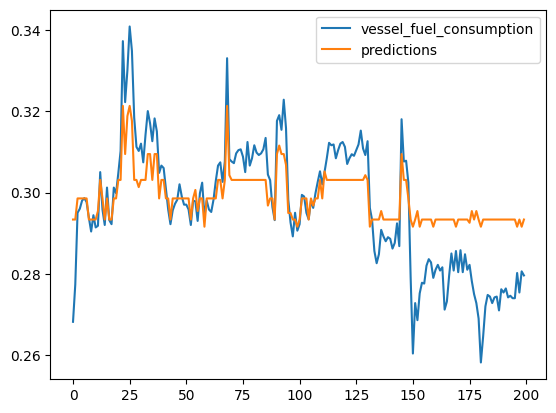

In [50]:
Y.plot()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
def _metrics_gen(true_value, predicted):
    mae = mean_absolute_error(true_value, predicted)
    mse = mean_squared_error(true_value, predicted)
    r2 = r2_score(true_value, predicted)
    return mae, mse, r2

In [53]:
_metrics_gen(true_value=Y['vessel_fuel_consumption'], predicted=Y['predictions'])

(0.008131403307347282, 0.0001127365136126676, 0.5279781533486597)